<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Canny-edge-detection" data-toc-modified-id="Canny-edge-detection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Canny edge detection</a></span><ul class="toc-item"><li><span><a href="#Step-1:-blur-with-Gaussian" data-toc-modified-id="Step-1:-blur-with-Gaussian-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Step 1: blur with Gaussian</a></span></li><li><span><a href="#Step-2:-compute-gradient-magnitude" data-toc-modified-id="Step-2:-compute-gradient-magnitude-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Step 2: compute gradient magnitude</a></span></li><li><span><a href="#step-3:-non-maximum-suppression" data-toc-modified-id="step-3:-non-maximum-suppression-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>step 3: non-maximum suppression</a></span></li><li><span><a href="#Step-4:-Edge-tracing-and-hysteresis-thresholding" data-toc-modified-id="Step-4:-Edge-tracing-and-hysteresis-thresholding-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Step 4: Edge tracing and hysteresis thresholding</a></span></li></ul></li></ul></div>

## Canny edge detection

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [8]:
def convolve_np(X, F):
    X_height = X.shape[0]
    X_width = X.shape[1]

    F_height = F.shape[0]
    F_width = F.shape[1]
    
    H = int((F_height - 1) / 2)
    W = int((F_width - 1) / 2)
    
    out = np.zeros((X_height, X_width))
    
    for i in np.arange(H, X_height-H):
        for j in np.arange(W, X_width-W):
            sum = 0
            for k in np.arange(-H, H+1):
                for l in np.arange(-W, W+1):
                    a = X[i+k, j+l]
                    w = F[H+k, W+l]
                    sum += (w * a)
            out[i,j] = sum
        
    return out

In [9]:
def get_orientation_sector(dx,dy):
    # rotate (dx,dy) by pi/8
    rotation = np.array([[np.cos(np.pi/8), -np.sin(np.pi/8)],
                          [np.sin(np.pi/8), np.cos(np.pi/8)]])
    rotated = np.dot(rotation, np.array([[dx], [dy]]))
    
    if rotated[1] < 0:
        rotated[0] = -rotated[0]
        rotated[1] = -rotated[1]
        
    s_theta = -1
    if rotated[0] >= 0 and rotated[0] >= rotated[1]:
        s_theta = 0
    elif rotated[0] >= 0 and rotated[0] < rotated[1]:
        s_theta = 1
    elif rotated[0] < 0 and -rotated[0] < rotated[1]:
        s_theta = 2
    elif rotated[0] < 0 and -rotated[0] >= rotated[1]:
        s_theta = 3
    
    return s_theta

In [10]:
def is_local_max(E_mag, i, j, s_theta, t_low):
    mC = E_mag[i,j]
    if mC < t_low:
        return False
    else:
        mL = -1
        if s_theta == 0:
            mL = E_mag[i, j-1]
        elif s_theta == 1:
            mL = E_mag[i-1, j-1]
        elif s_theta == 2:
            mL = E_mag[i-1, j]
        elif s_theta == 3:
            mL = E_mag[i-1, j+1]        
        
        mR = -1
        if s_theta == 0:
            mL = E_mag[i, j+1]
        elif s_theta == 1:
            mL = E_mag[i+1, j+1]
        elif s_theta == 2:
            mL = E_mag[i+1, j]
        elif s_theta == 3:
            mL = E_mag[i+1, j-1]
        
    return mL <= mC and mC >= mR

In [11]:
def trace_and_threshold(E_nms, E_bin, i, j, t_low):
    E_bin[i,j] = 255
    
    jL = np.max([j-1, 0])
    jR = np.min([j+1, E_bin.shape[1]])
    
    iT = np.max([i-1, 0])
    iB = np.min([i+1, E_bin.shape[0]])
    
    for ii in np.arange(iT, iB):
        for jj in np.arange(jL, jR):
            if E_nms[ii,jj] >= t_low and E_bin[ii,jj] == 0:
                trace_and_threshold(E_nms, E_bin, ii, jj, t_low)
                
    return

In [12]:
img = cv2.imread('images/butterfly.jpg', cv2.IMREAD_GRAYSCALE)

height = img.shape[0]
width = img.shape[1]


### Step 1: blur with Gaussian

In [13]:
gauss = (1.0/57) * np.array(
        [[0, 1, 2, 1, 0],
        [1, 3, 5, 3, 1],
        [2, 5, 9, 5, 2],
        [1, 3, 5, 3, 1],
        [0, 1, 2, 1, 0]])
img_blur = convolve_np(img, gauss)

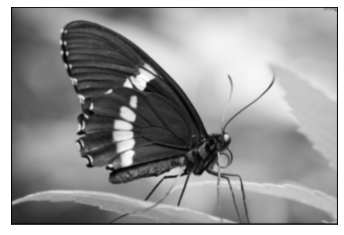

In [14]:
plt.imshow(img_blur, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

### Step 2: compute gradient magnitude

In [15]:
img_x = convolve_np(img_blur, np.array([[-0.5, 0, 0.5]]))
img_y = convolve_np(img_blur, np.array([[-0.5],
                                       [0],
                                       [0.5]]))
E_mag = np.sqrt(np.power(img_x, 2) + np.power(img_y, 2))
E_mag = (E_mag / np.max(E_mag)) * 255

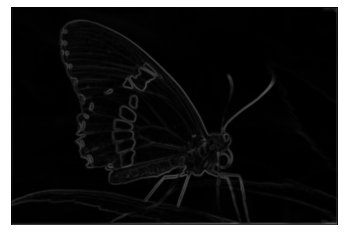

In [16]:
plt.imshow(E_mag, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

### step 3: non-maximum suppression

In [17]:
t_low = 4
E_nms = np.zeros((height, width))
for i in np.arange(1, height-1):
    for j in np.arange(1, width-1):
        dx = img_x[i,j]
        dy = img_y[i,j]
        s_theta = get_orientation_sector(dx,dy)
        
        if is_local_max(E_mag, i, j, s_theta, t_low):
            E_nms[i,j] = E_mag[i,j]


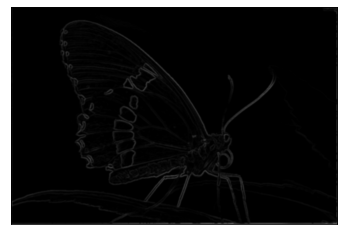

In [18]:
plt.imshow(E_nms, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

### Step 4: Edge tracing and hysteresis thresholding

In [19]:
t_high = 15
E_bin = np.zeros((height, width))
for i in np.arange(1, height-1):
    for j in np.arange(1, width-1):
        if E_nms[i,j] >= t_high and E_bin[i,j] == 0:
            trace_and_threshold(E_nms, E_bin, i, j, t_low)

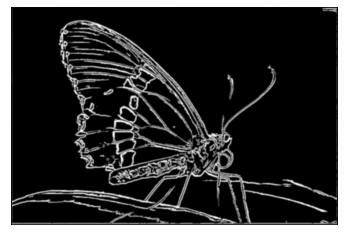

In [20]:
#cv2.imwrite('images/edge_canny.jpg', E_bin)

plt.imshow(E_bin, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()